# Setup the PEST(++) interface around the modified Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW6` model using `pyEMU`. We assume that the reader is at least partially familiar with PEST(++) file formats and working philosophy. 

The modified Freyberg groundwater flow model has been constructed and is described in a previous notebook from this series. We will construct the entire PEST(++) interface from scratch here. This setup will be built upon in subsequent tutorials. 

We will rely heavily on the `pyemu.PstFrom` class. Although here we employ it with a `MODFLOW6` model, `PstFrom` is designed to be general and software independent (mostly). Some features are only available for `MODFLOW` models (e.g. `SpatialReference`).

The `PstFrom` class automates the construction of high-dimensional PEST(++) interfaces with all the bells and whistles. It provides easy-to-use functions to process model input and output files into PEST(++) datasets. It can assist with setting up spatio-temporaly varying parameters. It handles the generation of geostatisical prior covariance matrices and ensembles. It automates writting a "model run" script. It provides tools to add custom pre- and post-processing functions to this script. It makes adding tweaks and fixes to the PEST(++) interface a breeze. All of this from the comfort of your favourite Python IDE.

During this tutorial we are going to construct a PEST dataset. Amongst other things, we will demonstrate:
 - how to add observations & parameters from model output & input files;
 - how to add pre- and post-processing functions to the "model run" script;
 - how to generate geostatistical structures for spatialy and temporally correlated parameters;
 - how to edit parameter/observation data sections;
 - how to generate a prior parameter covariance matrix and prior parameter ensemble;



First, let's get our model files and sort out some admin.


### 1. Admin & Organize Folders
First some admin. Load the dependencies and organize model folders. 

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pyemu
import flopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

We will be calling a few external programs throughout this tutorial. Namely, MODFLOW 6 and PEST++GLM. For the purposes of the tutorial(s), we have included executables in the tutorial repository. They are in the `bin` folder. 

Preferably, executables should be located in a folder that is cited in your computer’s PATH environment variable. Doing so allows you to run them from a command prompt open to any other folder without having to include the full path to these executables in the command to run them. 

Sometimes this may not be practical. In such cases, we can simply place the executables in the folder from which they will be executed.  So, let's copy the necessary executables into our working folder:


In [2]:
# specify a temporary folder; we will gather all our model and executable files here first
# this is to ensure we don't mess up our original model files
tmp_d = os.path.join('freyberg_mf6')

# get the necessary executables; OS agnostic
bin_dir = os.path.join('..','..','bin')

if "window" in platform.platform().lower():
    exe_files = [f for f in os.listdir(bin_dir) if f.endswith('exe')]
else:
    exe_files = [f for f in os.listdir(bin_dir) if not f.endswith('exe')]

# remove existing folder if it already exists
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)

# make the folder
os.mkdir(tmp_d)

# copy executables across
for exe_file in exe_files:
    shutil.copy2(os.path.join(bin_dir, exe_file),os.path.join(tmp_d,exe_file))

Let's copy the original model folder into a new working directory, just to ensure we don't mess up the base files.

In [3]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'freyberg_mf6')

# copy files across to the temp folder
for f in os.listdir(org_d):
    shutil.copy2(os.path.join(org_d,f), os.path.join(tmp_d,f))

If you inspect the model folder, you will see that all the `MODFLOW6` model files have been written "externally". This is key for working with the `PstFrom` class (or with PEST(++) in general, really). Essentialy, all pertinent model inputs have been written as independent files in either array or list format. This makes it easier for us to programiatically access and re-write the values in these files.

Array files contain a data type (usually floating points). List files will have a few columns that contain index information and then columns of floating point values (they have a tabular format; think `.csv` files or DataFrames). The `PstFrom` class provides methods for processing these file types into a PEST(++) dataset. 



In [4]:
os.listdir(tmp_d)

['freyberg6.dis',
 'freyberg6.dis.grb',
 'freyberg6.dis_botm_layer1.txt',
 'freyberg6.dis_botm_layer2.txt',
 'freyberg6.dis_botm_layer3.txt',
 'freyberg6.dis_delc.txt',
 'freyberg6.dis_delr.txt',
 'freyberg6.dis_idomain_layer1.txt',
 'freyberg6.dis_idomain_layer2.txt',
 'freyberg6.dis_idomain_layer3.txt',
 'freyberg6.dis_top.txt',
 'freyberg6.ghb',
 'freyberg6.ghb_stress_period_data_1.txt',
 'freyberg6.ic',
 'freyberg6.ic_strt_layer1.txt',
 'freyberg6.ic_strt_layer2.txt',
 'freyberg6.ic_strt_layer3.txt',
 'freyberg6.ims',
 'freyberg6.lst',
 'freyberg6.nam',
 'freyberg6.npf',
 'freyberg6.npf_icelltype_layer1.txt',
 'freyberg6.npf_icelltype_layer2.txt',
 'freyberg6.npf_icelltype_layer3.txt',
 'freyberg6.npf_k33_layer1.txt',
 'freyberg6.npf_k33_layer2.txt',
 'freyberg6.npf_k33_layer3.txt',
 'freyberg6.npf_k_layer1.txt',
 'freyberg6.npf_k_layer2.txt',
 'freyberg6.npf_k_layer3.txt',
 'freyberg6.oc',
 'freyberg6.rch',
 'freyberg6.rch_recharge_1.txt',
 'freyberg6.rch_recharge_10.txt',
 'freyb

Now we need just a tiny bit of info about the spatial discretization of the model - this is needed to work out separation distances between parameters to build a geostatistical prior covariance matrix later.

Here we will load the flopy sim and model instance just to help us define some quantities later - flopy is ***not required*** to use the `PstFrom` class. ***Neither is MODFLOW***. However, at the time of writting, support for `SpatialReference` to spatially locate parameters is limited to MODLOW models.

Load the simulation. Run it once to make sure it works and to ***make sure that model output files are in the folder***. 

In [5]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

# run the model once to make sure it works
sim.run_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...


    loading package obs...
  loading ims package freyberg6...
FloPy is using the following executable to run the model: D:\Workspace\hugm0001\programs\mf6.2.1\mf6.2.1\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any d

    Solving:  Stress period:     7    Time step:     1
    Solving:  Stress period:     8    Time step:     1
    Solving:  Stress period:     9    Time step:     1
    Solving:  Stress period:    10    Time step:     1
    Solving:  Stress period:    11    Time step:     1
    Solving:  Stress period:    12    Time step:     1
    Solving:  Stress period:    13    Time step:     1
    Solving:  Stress period:    14    Time step:     1
    Solving:  Stress period:    15    Time step:     1
    Solving:  Stress period:    16    Time step:     1
    Solving:  Stress period:    17    Time step:     1
    Solving:  Stress period:    18    Time step:     1
    Solving:  Stress period:    19    Time step:     1
    Solving:  Stress period:    20    Time step:     1
    Solving:  Stress period:    21    Time step:     1


    Solving:  Stress period:    22    Time step:     1
    Solving:  Stress period:    23    Time step:     1
    Solving:  Stress period:    24    Time step:     1
    Solving:  Stress period:    25    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/02 15:38:29
 Elapsed run time:  0.409 Seconds
 
 Normal termination of simulation.


(True, [])

### 2. Spatial Reference
Now we can instantiate a `SpatialReference`. This will later be passed to `PstFrom` to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters).

In [6]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "freyberg6.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)

   could not remove start_datetime


### 3. Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a `PstFrom` class instance. There are a few things that we need to specify up front:

 - the folder in which we currently have model files (e.g. `tmp_d`). PstFrom will copy all the files from this directory into a new "template" folder.
 - **template folder**: this is a folder in which the PEST dataset will be constructed. This folder/dataset will form the template for subsequent deployment of PEST(++). It is **not** where PEST(++) will be run.
 - **longnames**: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/obsveration names (PEST++ does not). Setting this value to False is only recommended if required. 
 - Whether the model is `zero based` or not.
 - (optional) the **spatial reference**, as previously discussed. This is only requried if using `pyEMU` to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite. 



In [7]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join("freyberg6_template")

# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime="1-1-2018") # required when specifying temporal correlation between parameters

2022-03-02 15:38:29.985953 starting: opening PstFrom.log for logging
2022-03-02 15:38:29.985953 starting PstFrom process
2022-03-02 15:38:29.985953 starting: setting up dirs
2022-03-02 15:38:29.985953 starting: removing existing new_d 'freyberg6_template'


2022-03-02 15:38:30.686859 finished: removing existing new_d 'freyberg6_template' took: 0:00:00.700906


2022-03-02 15:38:31.687168 starting: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template'


2022-03-02 15:38:35.040874 finished: copying original_d 'freyberg_mf6' to new_d 'freyberg6_template' took: 0:00:03.353706
2022-03-02 15:38:35.040874 finished: setting up dirs took: 0:00:05.054921


### 4. Observations

We now have a `PstFrom` instance assigned to the variable `pf`. For now it is only an empty container to which we can start adding "observations", "parameters" and other bits and bobs.

Lets start with observations because they are easier. `MODFLOW6` makes life even easier by recording observations in nicely organized .csv files. Isn't that a peach!

#### 4.1 Freyberg Recap
As you may recall from the "*intro to Freyberg*" tutorial, the model is configured to record time series of head at observation wells, and flux at three locations along the river. These are recorded in external .csv files named `heads.csv` and `sfr.csv`, respectively. You should be able to see these files in the model folder.

Recall that each .csv houses records of observation time-series. Outputs are recorded for each simulated stress-period. The model starts with a single steady-state stress-period, followed by 24 monthly transient stress-periods. The steady-state and first 12 transient stress-periods simulate the history-matching period. The last 12 transient stress periods simulate future conditions (i.e. the prediction period).

In [8]:
# check the output csv file names
for i in gwf.obs:
    print(i.output.obs_names)

['sfr.csv']
['heads.csv']


Let's start with the 'heads.csv' file. First load it as a DataFrame to take a look.

As you can see, there are many columns, one for each observation site. Conveniently, * *cough* * they are named according to the cell layer, row and column. Note that at every site, there is an observation in both the top and bottom layer (0_ and 2_). We will make use of this later to create "secondary observations" of head differences between layers...but let's not get distracted.

The values in the *.csv* file were generated by running the model. (***IMPORTANT!***) However, `PstFrom` assumes that values in this file are the *target* observation values, and they will be used to populate the PEST(++) dataset. Now, you can change these values later on if you wish. However, it can get a bit messy. So you either need to populate model output files with the target values, or update values in the PEST(++) dataset later on. Which approach you adopt is up to personal preference and/or specifics of your modelling workflow. 

We will demonstrate both in this notebook.

In [9]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)
df.head()

,TRGW_2_2_15,TRGW_2_2_9,TRGW_2_3_8,TRGW_2_9_1,TRGW_2_13_10,TRGW_2_15_16,TRGW_2_21_10,TRGW_2_22_15,TRGW_2_24_4,TRGW_2_26_6,...,TRGW_0_9_1,TRGW_0_13_10,TRGW_0_15_16,TRGW_0_21_10,TRGW_0_22_15,TRGW_0_24_4,TRGW_0_26_6,TRGW_0_29_15,TRGW_0_33_7,TRGW_0_34_10
time,,,,,,,,,,,,,,,,,,,,,
1.0,34.339320,34.581597,34.611207,34.872171,34.257574,34.136387,34.144465,34.027679,34.310857,34.171589,...,34.878082,34.263187,34.141599,34.150067,33.992380,34.316575,34.177206,33.909874,33.985755,33.890192
32.0,34.422442,34.680583,34.711735,34.972780,34.381277,34.245430,34.272372,34.137936,34.437224,34.313405,...,34.978637,34.386153,34.250207,34.277105,34.087328,34.442105,34.317746,33.992555,34.102614,34.005442
61.0,34.495792,34.777940,34.811524,35.082997,34.481415,34.330031,34.376051,34.218902,34.554365,34.427033,...,35.088895,34.487318,34.335784,34.381822,34.157748,34.559815,34.432489,34.057939,34.195593,34.085966
92.0,34.541159,34.848052,34.884477,35.177157,34.535630,34.371993,34.431372,34.257376,34.631046,34.490293,...,35.183306,34.542680,34.378691,34.438366,34.191361,34.637508,34.497058,34.090606,34.243600,34.120784
122.0,34.537851,34.859231,34.897712,35.213813,34.519752,34.353051,34.414135,34.236501,34.633417,34.475626,...,35.220315,34.527589,34.360284,34.422004,34.173543,34.640812,34.483430,34.076272,34.225665,34.095149


#### 4.2 Prepare Observation Files

We will start by populating our "model output" file with measured values. For this synthetic case, we conveniently have observations for all model output times and sites. (These "measured" values were generated using the same model with a randomly generated set of parameters; noise was added to all observations.)

In the next cell we read a .csv that contains measured obsevration values. As it has the exact same structure as our model output file, we can simpy replace the values in the model output file (and re-write it!). In real-world cases this step will likley be a bit more involved.

In [10]:
# read the measured head values
hds_meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"heads.meas.csv"),
                    index_col=0)

# re-write the model output .csv file with the measured values
hds_meas.to_csv(os.path.join(template_ws,"heads.csv"))

#### 4.2. Adding Observations

Now that our model output file contains the "target values", we can use the `PstFrom.add_observations()` method to add observations to our `pf` object. This method reads ***list-type*** files. The assumption is that these files are organized in a tabular format. 

We are going to tell `pf` which columns of this file contain observations. Values in these columns will be assigned to *observation values*.

We can also inform it if there is an index column. Values in this column will be included in the *observation names*. 

We could also specify which rows to include as observations. But observations are free...so why not keep them all! 

Let's add observations from `heads.csv`. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.


In [11]:
hds_df = pf.add_observations("heads.csv", # the model output file to read
                            insfile="heads.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy o find. We use it later on to select obsevrations

2022-03-02 15:38:35.079992 starting: adding observations from output file heads.csv
2022-03-02 15:38:35.079992 starting: adding observations from tabular output file '['heads.csv']'
2022-03-02 15:38:35.079992 starting: reading list-style file: freyberg6_template\heads.csv
2022-03-02 15:38:35.081986 finished: reading list-style file: freyberg6_template\heads.csv took: 0:00:00.001994
2022-03-02 15:38:35.081986 starting: building insfile for tabular output file heads.csv
2022-03-02 15:38:35.088968 finished: building insfile for tabular output file heads.csv took: 0:00:00.006982
2022-03-02 15:38:35.088968 starting: adding observation from instruction file 'freyberg6_template\heads.csv.ins'
2022-03-02 15:38:35.099938 finished: adding observation from instruction file 'freyberg6_template\heads.csv.ins' took: 0:00:00.010970
2022-03-02 15:38:35.100936 finished: adding observations from tabular output file '['heads.csv']' took: 0:00:00.020944


Let's inspect what we just created. 

We can see that the `.add_observations()` method returned a dataframe with lots of useful info: 

 - the observation names that were formed (see `obsnme` column); note that these inlcude lots of usefull metadata like the column name, index value and so on;
 - the values that were read from `heads.csv` (see `obsval` column); 
 - some generic weights and group names; note that observations are grouped according to the column of the model output .csv. Alternatively, we could have specified a list of observation group names.

In [12]:
hds_df.head()

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10


At this point, no PEST *control file* has been created, we have simply prepared to add these observations to the control file later. Everything is still only stored in memory. However, a PEST *instruction* file has been created in the template folder (`template_ws`):

In [13]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['heads.csv.ins']

Blimey, wasn't that easy? Automatically assimilating thousands of observations into a PEST dataset becomes a breeze!

Let's quickly do the same thing for the SFR observations.

In [14]:
df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)
df.head()

,HEADWATER,TAILWATER,GAGE_1
time,,,
1.0,-644.10,-477.76,1205.3
32.0,-864.75,-637.87,1635.7
61.0,-1033.10,-764.28,1937.0
92.0,-1117.80,-824.86,2072.0
122.0,-1082.30,-794.46,1982.3


In [15]:
# read the measured  values
meas = pd.read_csv(os.path.join('..', '..', 'models', 'freyberg_mf6_truth',"sfr.meas.csv"),
                    index_col=0)
# re-write the model output .csv file with the measured values
meas.to_csv(os.path.join(template_ws,"sfr.csv"))
# add the observations to pf
sfr_df = pf.add_observations("sfr.csv", # the model output file to read
                            insfile="sfr.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfr") #prefix to all observation names

2022-03-02 15:38:35.129614 starting: adding observations from output file sfr.csv
2022-03-02 15:38:35.129614 starting: adding observations from tabular output file '['sfr.csv']'
2022-03-02 15:38:35.129614 starting: reading list-style file: freyberg6_template\sfr.csv
2022-03-02 15:38:35.130611 finished: reading list-style file: freyberg6_template\sfr.csv took: 0:00:00.000997
2022-03-02 15:38:35.130611 starting: building insfile for tabular output file sfr.csv
2022-03-02 15:38:35.136595 finished: building insfile for tabular output file sfr.csv took: 0:00:00.005984
2022-03-02 15:38:35.136595 starting: adding observation from instruction file 'freyberg6_template\sfr.csv.ins'
2022-03-02 15:38:35.141582 finished: adding observation from instruction file 'freyberg6_template\sfr.csv.ins' took: 0:00:00.004987
2022-03-02 15:38:35.142580 finished: adding observations from tabular output file '['sfr.csv']' took: 0:00:00.012966


### 5. Parameters

The `PstFrom.add_parameters()` method reads model input files and adds parameters to the PEST(++) dataset. Parameterisation can be configured in several ways. 

 - model input files can be in array or list format;
 - parameters can be setup as different "types". Values in model input files can (1) each be a separate parameter, (2) be grouped into "zones" or (3) all be treated as a single parameter. Alteratvely, (4) parameters can be assigned to pilot points, from which individual parameter values are subsequently interpolated. `PstFrom` adds the relevant pre-processing steps to assign paramter values directly into the "model run" script.
 - parameter values can be setup as "direct", "multiplier" or "addend". This means the "parameter value" which PEST(++) sees can be (1) the same value the model sees, (2) a multiplier on the value in the model input file, or (3) a value which is added to the value in the model input file. This is very nifty. `PstFrom` is designed to preferentially use parameters setup as multipliers. These let us preserve the existing model inputs and treat them as the mean of the prior parameter distribution. Once again, relevant pre-processing scripts are automatically added to the "model run" script (discussed later).


#### 5.1. Freyberg Recap

As discussed, all model inputs are stored in external files. Some are arrays. Others are lists. Recall that our model has 3 layers. It is transient. Hydraulic properties (Kh, Kv, Ss, Sy) vary in space. Recharge varies over both space and time. We have GHBs, SFR and WEL boundary conditions. GHB parameters are constant over time, but vary spatially. SFR inflow varies over time. Pumping rates of individual wells are uncertain in space and and time.

All of these have some degree of spatial and/or temporal correlation.

#### 5.2. Geostatistical Structures

Parameter correlation plays a role in (1) regularization when giving preference to the emergence of patterns of spatial heterogeneity and (2) when specifying the prior parameter probability distribution. Since we are all sophisticated and recognize the importance of expressing spatial and temporal uncertainty (e.g. heterogeneity) in the model inputs (and the corresponding spatial correlation in those uncertain inputs), let's use geostatistics to express uncertainty. To do that we need to define "geostatistical structures". 

For the sake of this tutorial, let's assume that heterogeneity in all spatially distributed parameters share the same statistical characteristics. Likewise for temporally varying parameters. We will therefore only  construct two geostatisitcal structures.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

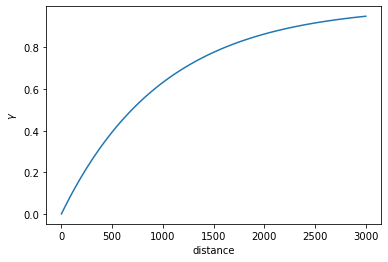

In [16]:
# exponential variogram for spatially varying parameters
v_space = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=1000, # range of correlation; length units of the model. In our case 'meters'
                                    anisotropy=1.0, #name says it all
                                    bearing=0.0 #angle in degrees East of North corresponding to anisotropy ellipse
                                    )

# geostatistical structure for spatially varying parameters
grid_gs = pyemu.geostats.GeoStruct(variograms=v_space, transform='log') 

# plot the gs if you like:
grid_gs.plot()

In [17]:
# exponential variogram for time varying parameters
v_time = pyemu.geostats.ExpVario(contribution=1.0, #sill
                                    a=60, # range of correlation; length time units (days)
                                    anisotropy=1.0, #do not change for 1-D time
                                    bearing=0.0 #do not change for 1-D time
                                    )

# geostatistical structure for time varying parameters
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none') 

#### 5.3. Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

First, find all the external array files that contain Kh values. In our case, these are the files with "npf_k_" in the file name. As you can see below, there is one file for each model layer. 

In [18]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.npf_k_layer1.txt', 'freyberg6.npf_k_layer2.txt', 'freyberg6.npf_k_layer3.txt']


Let's setup multiple spatial scales of parameters for Kh. To do this we will use three of the parameter "types" described above. The coarse scale will be a `constant` single value for each array. The medium scale will `pilot points`. The finest scale will use parameters as the `grid` scale (a unique parameter for each model cell!)

Each scale of parameters will work with the others as multipliers with the existing Kh arrays. (This all happens at runtime as part of the "model run" script.) Think of the scales as dials that PEST(++) can turn to improve the fit. The "coarse" scale is one big dial that alows PEST to move everything at once. The "medium" dials are few (but not too many) that allow PEST to adjust broad areas, but not making eveything move. The "fine" scales are lots of small dials that allow PEST(++) to have very detailed control, tweaking parameter values within very small areas. 

However, because we are working with parameter `multipliers`, we will need to specify two sets of parameter bounds: 
 - `upper_bound` and `lower_bound` are the standard control file bounds, while
 - `ult_ubound` and `ult_lbound` are bounds that are applied at runtime to the resulting (multiplied out) model input array. 
 
Since we are using sets of multipliers, it is important to make sure we keep the resulting model input arrays within the range of realistic values.

#### 5.3.1. Array Files

We will first demonstrate steb-by-step for `freyberg6.npf_k_layer1.txt`. We will start with grid scale parameters. These are multipliers assigned to each individual value in the array.

We start by getting the idomain array. As our model has inactive cells, this heps us avoid adding unncessary parameters. It is also required later when generating pilot points.

In [19]:
# as IDOMIAN is the same in all layers, we can use any layer
ib = gwf.dis.idomain.get_data(layer=0)

In [20]:
f = 'freyberg6.npf_k_layer1.txt'

# grid (fine) scale parameters
df_gr = pf.add_parameters(f,
                zone_array=ib, #as we have inactie model cells, we can avoid assigning these as parameters
                par_type="grid", #specify the type, these will be unique parameters for each cell
                geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                lower_bound=0.2, upper_bound=5.0, #parameter lower and upper bound
                ult_ubound=100, ult_lbound=0.01 # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                )

2022-03-02 15:38:35.482260 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 15:38:35.482260 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 15:38:35.484255 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.001995
2022-03-02 15:38:35.484255 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 15:38:35.485252 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:35.485252 starting: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0']
2022-03-02 15:38:35.495225 finished: writing template file freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl for ['npf_k_layer1_gr_inst:0'] took: 0:00:00.009973
2022-03-02 15:38:35.496162 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl'
2022-0

As when adding observations,  `pf.add_parameters()` returns a dataframe. Take a look. You may recognize alot of the information that appears in a PEST `*parameter data` section. All of this is still only housed in memory for now. We will write the PEST control file later on.

In [21]:
df_gr.head()

,parnme,parval1,i,j,x,y,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,offset,dercom,scale,parchglim
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,1.0,0,0,125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1,1.0,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,1.0,0,1,375.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1,1.0,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,1.0,0,2,625.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1,1.0,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,1.0,0,3,875.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1,1.0,factor
pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npf_k_layer1_gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,1.0,0,4,1125.0,9875.0,npf_k_layer1_gr,freyberg6_template\npf_k_layer1_gr_inst0_grid.csv.tpl,freyberg6_template\mult\npf_k_layer1_gr_inst0_grid.csv,grid,log,5.0,0.2,0.0,1,1.0,factor


Now, we add pilot point (medium scale) multiplier parameters to the same model input file. These multipliers are assigned to pilot points, which are subsequently interpolated to values in the array.

You can add pilot points in two ways:

1. `PstFrom` can generate them for you on a regular grid or 
2. you can supply `PstFrom` with existing pilot point location information. 

When you change `par_type` to "pilotpoints", by default, a regular grid of pilot points is setup using a default `pp_space` value of 10 (which is every 10th row and column). You can chnge this spacing by passing a integer to `pp_space` (as demonstrated below). 

Alternatively you can specify a filename or dataframe with pilot point locations. If you supply `pp_space` as a `str` it is assumed to be a filename. The extension is the guide: ".csv" for dataframe, ".shp" for shapefile (point-type). Anything else and the file is assumed to be a pilot points file type. The dataframe (or .csv file) must have "name", "x", and "y" as columns - it can have more, but must have those. 

In [22]:
# pilot point (medium) scale parameters
df_pp = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="pilotpoints",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_pp",
                    pargp=f.split('.')[1]+"_pp",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01,
                    pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

2022-03-02 15:38:35.521292 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 15:38:35.521292 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 15:38:35.522261 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000969
2022-03-02 15:38:35.523289 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 15:38:35.524293 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_pp_inst0_pilotpoints.csv.tpl'
2022-03-02 15:38:35.524293 starting: setting up pilot point parameters
2022-03-02 15:38:35.524293 No spatial reference (containing cell spacing) passed.
2022-03-02 15:38:35.524293 OK - using spatial reference in parent object.
2022-03-02 15:38:35.635354 32 pilot point parameters created
2022-03-02 15:38:35.635354 pilot point 'pargp':npf_k_layer1_pp
2022-03-02 15:38:35.635354 finished: setting up pilot point parameters took: 

starting 0
starting 1


starting 2
starting 3


starting 4
starting 5


starting 6
starting 7


starting 8
starting 9


took 3.389345 seconds
2022-03-02 15:38:39.065586 finished: calculating factors for pargp=npf_k_layer1_pp took: 0:00:03.425250
2022-03-02 15:38:39.065586 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl'
2022-03-02 15:38:39.065586 saving zone array freyberg6_template\npf_k_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer1_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.069326 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt'] took: 0:00:03.548034


Lastly, add the constant (coarse) parameter multiplier. This is a single multiplier value applied to all values in the array. 

In [23]:
# constant (coarse) scale parameters
df_cst = pf.add_parameters(f,
                    zone_array=ib,
                    par_type="constant",
                    geostruct=grid_gs,
                    par_name_base=f.split('.')[1]+"_cn",
                    pargp=f.split('.')[1]+"_cn",
                    lower_bound=0.2,upper_bound=5.0,
                    ult_ubound=100, ult_lbound=0.01)

2022-03-02 15:38:39.076308 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer1.txt']
2022-03-02 15:38:39.076308 starting: loading array freyberg6_template\freyberg6.npf_k_layer1.txt
2022-03-02 15:38:39.077305 finished: loading array freyberg6_template\freyberg6.npf_k_layer1.txt took: 0:00:00.000997
2022-03-02 15:38:39.077305 loaded array 'freyberg_mf6\freyberg6.npf_k_layer1.txt' of shape (40, 20)
2022-03-02 15:38:39.078302 starting: writing array-style template file 'freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.078302 starting: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0']
2022-03-02 15:38:39.084286 finished: writing template file freyberg6_template\npf_k_layer1_cn_inst0_constant.csv.tpl for ['npf_k_layer1_cn_inst:0'] took: 0:00:00.005984
2022-03-02 15:38:39.084286 starting: writing array-based template file 'freyberg6_template\npf_k_layer1_cn_inst0_cons

Let's do that for Kh in the other layers. We are going to be doing this a few times, so lets write a function.

In [24]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100):
    # grid (fine) scale parameters
    pf.add_parameters(f,
                    zone_array=ib,
                    par_type="grid", #specify the type, these will be unique parameters for each cell
                    geostruct=grid_gs, # the gestatisical structure for spatial correlation 
                    par_name_base=f.split('.')[1]+"_gr", #specify a parameter name base that allows us to easily identify the filename and parameter type. "_gr" for "grid", and so forth.
                    pargp=f.split('.')[1]+"_gr", #likewise for the parameter group name
                    lower_bound=lb, upper_bound=ub, #parameter lower and upper bound
                    ult_ubound=uub, ult_lbound=ulb # The ultimate bounds for multiplied model input values. Here we are stating that, after accounting for all multipliers, Kh cannot exceed these values. Very important with multipliers
                    )
                    
    # pilot point (medium) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="pilotpoints",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_pp",
                        pargp=f.split('.')[1]+"_pp",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb,
                        pp_space=4) # `PstFrom` will generate a unifrom grid of pilot points in every 4th row and column

    # constant (coarse) scale parameters
    pf.add_parameters(f,
                        zone_array=ib,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=f.split('.')[1]+"_cn",
                        pargp=f.split('.')[1]+"_cn",
                        lower_bound=lb, upper_bound=ub,
                        ult_ubound=uub, ult_lbound=ulb)
    return

In [25]:
for f in files[1:]:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

2022-03-02 15:38:39.101021 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer2.txt']
2022-03-02 15:38:39.101021 starting: loading array freyberg6_template\freyberg6.npf_k_layer2.txt
2022-03-02 15:38:39.102019 finished: loading array freyberg6_template\freyberg6.npf_k_layer2.txt took: 0:00:00.000998
2022-03-02 15:38:39.102019 loaded array 'freyberg_mf6\freyberg6.npf_k_layer2.txt' of shape (40, 20)
2022-03-02 15:38:39.104046 starting: writing array-style template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:39.104046 starting: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0']
2022-03-02 15:38:39.114050 finished: writing template file freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl for ['npf_k_layer2_gr_inst:0'] took: 0:00:00.010004
2022-03-02 15:38:39.114050 starting: writing array-based template file 'freyberg6_template\npf_k_layer2_gr_inst0_grid.csv.tpl'
2022-0

2022-03-02 15:38:39.211732 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:39.211732 saving zone array freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.zone for tpl file freyberg6_template\npf_k_layer3_gr_inst0_grid.csv.tpl
2022-03-02 15:38:39.216709 finished: adding grid type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.018014
2022-03-02 15:38:39.216709 starting: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-02 15:38:39.216709 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-02 15:38:39.217677 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.000968
2022-03-02 15:38:39.217677 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt' of shape (40, 20)
2022-03-02 15:38:39.219703 starting: writing array-style template file 'freyberg6_template\npf_k_layer3_pp_inst0_pilotpoints.csv.tp

2022-03-02 15:38:39.272681 pilot point 'pargp':npf_k_layer3_pp
2022-03-02 15:38:39.272681 finished: setting up pilot point parameters took: 0:00:00.052978
2022-03-02 15:38:39.277639 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl'
2022-03-02 15:38:39.278637 saving zone array freyberg6_template\npf_k_layer3_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k_layer3_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.281661 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.064952
2022-03-02 15:38:39.281661 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt']
2022-03-02 15:38:39.281661 starting: loading array freyberg6_template\freyberg6.npf_k_layer3.txt
2022-03-02 15:38:39.282654 finished: loading array freyberg6_template\freyberg6.npf_k_layer3.txt took: 0:00:00.000993
2022-03-02 15:38:39.283652 loaded array 'freyberg_mf6\freyberg6.npf_k_layer3.txt'

2022-03-02 15:38:39.290633 starting: writing array-based template file 'freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.290633 saving zone array freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k_layer3_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.294594 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k_layer3.txt'] took: 0:00:00.012933


Well...hot damn, wasn't that easy? Let's speed through the other array parameter files.

In [26]:
# for Kv
tag = "npf_k33"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100)

# for Ss
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 2 and 3; we aren't monsters
for f in files[1:]: 
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=1e-6, uub=1e-3)

# For Sy
tag = "sto_sy"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
# only for layer 1
f = files[0]
add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=0.4)


2022-03-02 15:38:39.303795 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt']
2022-03-02 15:38:39.303795 starting: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt
2022-03-02 15:38:39.304822 finished: loading array freyberg6_template\freyberg6.npf_k33_layer1.txt took: 0:00:00.001027
2022-03-02 15:38:39.304822 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer1.txt' of shape (40, 20)
2022-03-02 15:38:39.306819 starting: writing array-style template file 'freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:39.306819 starting: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0']
2022-03-02 15:38:39.315796 finished: writing template file freyberg6_template\npf_k33_layer1_gr_inst0_grid.csv.tpl for ['npf_k33_layer1_gr_inst:0'] took: 0:00:00.008977
2022-03-02 15:38:39.315796 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_gr_inst0_

2022-03-02 15:38:39.395579 starting: writing array-based template file 'freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.396545 saving zone array freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k33_layer1_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.400566 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer1.txt'] took: 0:00:00.013960
2022-03-02 15:38:39.400566 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-02 15:38:39.400566 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-02 15:38:39.401533 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000967
2022-03-02 15:38:39.402583 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-02 15:38:39.403935 starting: writing array-style template file 'freyberg6_template\npf_k33_layer2_

2022-03-02 15:38:39.475261 finished: setting up pilot point parameters took: 0:00:00.052852
2022-03-02 15:38:39.480247 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl'
2022-03-02 15:38:39.480247 saving zone array freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\npf_k33_layer2_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.484236 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.064851
2022-03-02 15:38:39.484236 starting: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt']
2022-03-02 15:38:39.484236 starting: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt
2022-03-02 15:38:39.485234 finished: loading array freyberg6_template\freyberg6.npf_k33_layer2.txt took: 0:00:00.000998
2022-03-02 15:38:39.485234 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer2.txt' of shape (40, 20)
2022-03-02 15:38:39.487229 s

2022-03-02 15:38:39.493213 starting: writing array-based template file 'freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.494186 saving zone array freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k33_layer2_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.498199 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer2.txt'] took: 0:00:00.013963
2022-03-02 15:38:39.498199 starting: adding grid type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt']
2022-03-02 15:38:39.499207 starting: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt
2022-03-02 15:38:39.500193 finished: loading array freyberg6_template\freyberg6.npf_k33_layer3.txt took: 0:00:00.000986
2022-03-02 15:38:39.500193 loaded array 'freyberg_mf6\freyberg6.npf_k33_layer3.txt' of shape (40, 20)
2022-03-02 15:38:39.501202 starting: writing array-style template file 'freyberg6_template\npf_k33_layer3_

2022-03-02 15:38:39.583070 starting: writing template file freyberg6_template\npf_k33_layer3_cn_inst0_constant.csv.tpl for ['npf_k33_layer3_cn_inst:0']
2022-03-02 15:38:39.589080 finished: writing template file freyberg6_template\npf_k33_layer3_cn_inst0_constant.csv.tpl for ['npf_k33_layer3_cn_inst:0'] took: 0:00:00.006010
2022-03-02 15:38:39.589080 starting: writing array-based template file 'freyberg6_template\npf_k33_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.589080 saving zone array freyberg6_template\npf_k33_layer3_cn_inst0_constant.csv.zone for tpl file freyberg6_template\npf_k33_layer3_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.594066 finished: adding constant type m style parameters for file(s) ['freyberg6.npf_k33_layer3.txt'] took: 0:00:00.013020
2022-03-02 15:38:39.594066 starting: adding grid type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-02 15:38:39.595064 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-

2022-03-02 15:38:39.665612 pilot point 'pargp':sto_ss_layer2_pp
2022-03-02 15:38:39.665612 finished: setting up pilot point parameters took: 0:00:00.050601
2022-03-02 15:38:39.670629 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl'
2022-03-02 15:38:39.670629 saving zone array freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_ss_layer2_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.674626 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.062607
2022-03-02 15:38:39.674626 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt']
2022-03-02 15:38:39.675586 starting: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt
2022-03-02 15:38:39.676613 finished: loading array freyberg6_template\freyberg6.sto_ss_layer2.txt took: 0:00:00.001027


2022-03-02 15:38:39.676613 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer2.txt' of shape (40, 20)
2022-03-02 15:38:39.677606 starting: writing array-style template file 'freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.678583 starting: writing template file freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl for ['sto_ss_layer2_cn_inst:0']
2022-03-02 15:38:39.683608 finished: writing template file freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl for ['sto_ss_layer2_cn_inst:0'] took: 0:00:00.005025
2022-03-02 15:38:39.683608 starting: writing array-based template file 'freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.683608 saving zone array freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.zone for tpl file freyberg6_template\sto_ss_layer2_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.688579 finished: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer2.txt'] took: 0:00:00.01

2022-03-02 15:38:39.769992 loaded array 'freyberg_mf6\freyberg6.sto_ss_layer3.txt' of shape (40, 20)
2022-03-02 15:38:39.771957 starting: writing array-style template file 'freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.771957 starting: writing template file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl for ['sto_ss_layer3_cn_inst:0']
2022-03-02 15:38:39.777970 finished: writing template file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl for ['sto_ss_layer3_cn_inst:0'] took: 0:00:00.006013
2022-03-02 15:38:39.777970 starting: writing array-based template file 'freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.777970 saving zone array freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.zone for tpl file freyberg6_template\sto_ss_layer3_cn_inst0_constant.csv.tpl
2022-03-02 15:38:39.781958 finished: adding constant type m style parameters for file(s) ['freyberg6.sto_ss_layer3.txt'] took: 0:00:00.01

2022-03-02 15:38:39.857818 pilot point 'pargp':sto_sy_layer1_pp
2022-03-02 15:38:39.858815 finished: setting up pilot point parameters took: 0:00:00.055821
2022-03-02 15:38:39.863833 starting: writing array-based template file 'freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl'


2022-03-02 15:38:39.863833 saving zone array freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.zone for tpl file freyberg6_template\sto_sy_layer1_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.867818 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt'] took: 0:00:00.067814
2022-03-02 15:38:39.867818 starting: adding constant type m style parameters for file(s) ['freyberg6.sto_sy_layer1.txt']
2022-03-02 15:38:39.867818 starting: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt
2022-03-02 15:38:39.868819 finished: loading array freyberg6_template\freyberg6.sto_sy_layer1.txt took: 0:00:00.001001
2022-03-02 15:38:39.869826 loaded array 'freyberg_mf6\freyberg6.sto_sy_layer1.txt' of shape (40, 20)
2022-03-02 15:38:39.870811 starting: writing array-style template file 'freyberg6_template\sto_sy_layer1_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:39.870811 starting: writing template file freyberg6_template\sto_sy_layer1_cn_inst0_constant.csv.tpl for

#### 5.3.2. Spatial and Temporal Correlation

Now, you may be thinking "shouldn't recharge have temporal correlation as well?". 

Damn straight it should. Now, this requires a little trickery.

First we need to construct a container of stress period datetimes. (This relies on specifying the start_datetime argument when instantiating `PstFrom`.) These datetime values will specify the postion of parameters on the time-axis.



In [27]:
# build up a container of stress period start datetimes - this will
# be used to specify the datetime of each multipler parameter
start_datetime="1-1-2018"
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')

dts

DatetimeIndex(['2018-01-02', '2018-02-02', '2018-03-03', '2018-04-03',
               '2018-05-03', '2018-06-03', '2018-07-03', '2018-08-03',
               '2018-09-03', '2018-10-03', '2018-11-03', '2018-12-03',
               '2019-01-03', '2019-02-03', '2019-03-03', '2019-04-03',
               '2019-05-03', '2019-06-03', '2019-07-03', '2019-08-03',
               '2019-09-03', '2019-10-03', '2019-11-03', '2019-12-03',
               '2020-01-03'],
              dtype='datetime64[ns]', freq=None)

If you use the same parameter group name (`pargp`) and same geostruct, `PstFrom` will treat parameters setup across different calls to `add_parameters()` as correlated.  In this case, we want to express temporal correlation in the recharge multiplier parameters. So, we use the same parameter group names for each stress period data file, and specify the `datetime` and `geostruct` arguments.

Including temporal correlation introduces an additional challenge. Interpolation between points that share a common coordinate creates all types of trouble. We are going to have many parameters during each stress period (a single point on the time-axis). To get around this challenge we need to be a bit sneaky.


First, we will apply the multiple *spatial* scales of parameter multiplers (`constant`, `pilot point` and `grid`) as we did for hyraulic properties. 

Then, we will asign an additional `constant` multiplier parameter for each recharge stress-period file (so, a single multiplier for all recharge paramaters for each stress period). We will specify temporal correlation for these `constant` multipliers. These will all have the same parameter group name, as discussed above. 

In [28]:
# for Recharge; 
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    # the spatial multiplier parameters; just use the same function
    add_mult_pars(f, lb=0.2, ub=5.0, ulb=2e-5, uub=2e-4)
    
    
    # multiplier that includes temporal correlation
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                    zone_array=ib,
                    par_type="constant",
                    par_name_base=f.split('.')[1]+"_tcn",
                    pargp=f.split('.')[1]+"_tcn",
                    lower_bound=0.5, upper_bound=1.5,
                    ult_ubound=2e-4, ult_lbound=2e-5,
                    datetime=dts[kper], # this places the parameter value on the "time axis"
                    geostruct=temporal_gs)

2022-03-02 15:38:39.900744 starting: adding grid type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-02 15:38:39.900744 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-02 15:38:39.901728 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.000984
2022-03-02 15:38:39.901728 loaded array 'freyberg_mf6\freyberg6.rch_recharge_1.txt' of shape (40, 20)
2022-03-02 15:38:39.903725 starting: writing array-style template file 'freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:39.903725 starting: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0']
2022-03-02 15:38:39.914663 finished: writing template file freyberg6_template\rch_recharge_1_gr_inst0_grid.csv.tpl for ['rch_recharge_1_gr_inst:0'] took: 0:00:00.010938
2022-03-02 15:38:39.914663 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_gr_inst0_

2022-03-02 15:38:39.978492 pilot point 'pargp':rch_recharge_1_pp
2022-03-02 15:38:39.978492 finished: setting up pilot point parameters took: 0:00:00.054815
2022-03-02 15:38:39.983508 starting: writing array-based template file 'freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl'
2022-03-02 15:38:39.984506 saving zone array freyberg6_template\rch_recharge_1_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_1_pp_inst0pp.dat.tpl
2022-03-02 15:38:39.988510 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt'] took: 0:00:00.067834
2022-03-02 15:38:39.988510 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_1.txt']
2022-03-02 15:38:39.988510 starting: loading array freyberg6_template\freyberg6.rch_recharge_1.txt
2022-03-02 15:38:39.990491 finished: loading array freyberg6_template\freyberg6.rch_recharge_1.txt took: 0:00:00.001981
2022-03-02 15:38:39.990491 loaded array 'freyberg_mf6\freyberg6.r

2022-03-02 15:38:40.039329 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001965
2022-03-02 15:38:40.039329 loaded array 'freyberg_mf6\freyberg6.rch_recharge_10.txt' of shape (40, 20)
2022-03-02 15:38:40.041354 starting: writing array-style template file 'freyberg6_template\rch_recharge_10_pp_inst0_pilotpoints.csv.tpl'
2022-03-02 15:38:40.041354 starting: setting up pilot point parameters
2022-03-02 15:38:40.041354 No spatial reference (containing cell spacing) passed.
2022-03-02 15:38:40.041354 OK - using spatial reference in parent object.


2022-03-02 15:38:40.095250 32 pilot point parameters created


2022-03-02 15:38:40.095250 pilot point 'pargp':rch_recharge_10_pp
2022-03-02 15:38:40.095250 finished: setting up pilot point parameters took: 0:00:00.053896
2022-03-02 15:38:40.100234 starting: writing array-based template file 'freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.101237 saving zone array freyberg6_template\rch_recharge_10_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_10_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.104223 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt'] took: 0:00:00.066859
2022-03-02 15:38:40.105193 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_10.txt']
2022-03-02 15:38:40.105193 starting: loading array freyberg6_template\freyberg6.rch_recharge_10.txt
2022-03-02 15:38:40.106219 finished: loading array freyberg6_template\freyberg6.rch_recharge_10.txt took: 0:00:00.001026
2022-03-02 15:38:40.106219 loaded array 'freyberg_mf6\fre

2022-03-02 15:38:40.207964 32 pilot point parameters created
2022-03-02 15:38:40.207964 pilot point 'pargp':rch_recharge_11_pp
2022-03-02 15:38:40.207964 finished: setting up pilot point parameters took: 0:00:00.051880
2022-03-02 15:38:40.213932 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.213932 saving zone array freyberg6_template\rch_recharge_11_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_11_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.217919 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.065824
2022-03-02 15:38:40.217919 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-02 15:38:40.217919 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-02 15:38:40.218915 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.000

2022-03-02 15:38:40.226895 starting: writing array-based template file 'freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl'
2022-03-02 15:38:40.226895 saving zone array freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_11_cn_inst0_constant.csv.tpl
2022-03-02 15:38:40.230887 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt'] took: 0:00:00.012968
2022-03-02 15:38:40.230887 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_11.txt']
2022-03-02 15:38:40.230887 starting: loading array freyberg6_template\freyberg6.rch_recharge_11.txt
2022-03-02 15:38:40.231852 finished: loading array freyberg6_template\freyberg6.rch_recharge_11.txt took: 0:00:00.000965
2022-03-02 15:38:40.231852 loaded array 'freyberg_mf6\freyberg6.rch_recharge_11.txt' of shape (40, 20)
2022-03-02 15:38:40.233883 starting: writing array-style template file 'freyberg6_template\rch

2022-03-02 15:38:40.317449 32 pilot point parameters created
2022-03-02 15:38:40.318585 pilot point 'pargp':rch_recharge_12_pp
2022-03-02 15:38:40.318585 finished: setting up pilot point parameters took: 0:00:00.052454
2022-03-02 15:38:40.322572 starting: writing array-based template file 'freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.323569 saving zone array freyberg6_template\rch_recharge_12_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_12_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.326561 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt'] took: 0:00:00.063898
2022-03-02 15:38:40.326561 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_12.txt']
2022-03-02 15:38:40.327559 starting: loading array freyberg6_template\freyberg6.rch_recharge_12.txt
2022-03-02 15:38:40.327559 finished: loading array freyberg6_template\freyberg6.rch_recharge_12.txt took: 0:00:00
202

2022-03-02 15:38:40.425522 32 pilot point parameters created
2022-03-02 15:38:40.425522 pilot point 'pargp':rch_recharge_13_pp
2022-03-02 15:38:40.425522 finished: setting up pilot point parameters took: 0:00:00.051101
2022-03-02 15:38:40.430505 starting: writing array-based template file 'freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.430505 saving zone array freyberg6_template\rch_recharge_13_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_13_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.438467 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt'] took: 0:00:00.067039
2022-03-02 15:38:40.438467 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_13.txt']
2022-03-02 15:38:40.438467 starting: loading array freyberg6_template\freyberg6.rch_recharge_13.txt
2022-03-02 15:38:40.439486 finished: loading array freyberg6_template\freyberg6.rch_recharge_13.txt took: 0:00:00.001

2022-03-02 15:38:40.542185 32 pilot point parameters created
2022-03-02 15:38:40.543182 pilot point 'pargp':rch_recharge_14_pp
2022-03-02 15:38:40.543182 finished: setting up pilot point parameters took: 0:00:00.051841
2022-03-02 15:38:40.548169 starting: writing array-based template file 'freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.548169 saving zone array freyberg6_template\rch_recharge_14_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_14_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.551161 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt'] took: 0:00:00.063810
2022-03-02 15:38:40.551161 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_14.txt']
2022-03-02 15:38:40.552158 starting: loading array freyberg6_template\freyberg6.rch_recharge_14.txt
2022-03-02 15:38:40.553156 finished: loading array freyberg6_template\freyberg6.rch_recharge_14.txt took: 0:00:00.000

2022-03-02 15:38:40.598513 OK - using spatial reference in parent object.
2022-03-02 15:38:40.652918 32 pilot point parameters created
2022-03-02 15:38:40.652918 pilot point 'pargp':rch_recharge_15_pp
2022-03-02 15:38:40.652918 finished: setting up pilot point parameters took: 0:00:00.054405
2022-03-02 15:38:40.658914 starting: writing array-based template file 'freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.658914 saving zone array freyberg6_template\rch_recharge_15_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_15_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.662922 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt'] took: 0:00:00.066434
2022-03-02 15:38:40.663929 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_15.txt']
2022-03-02 15:38:40.663929 starting: loading array freyberg6_template\freyberg6.rch_recharge_15.txt
2022-03-02 15:38:40.664911 finished: loadin

2022-03-02 15:38:40.775544 32 pilot point parameters created
2022-03-02 15:38:40.775544 pilot point 'pargp':rch_recharge_16_pp
2022-03-02 15:38:40.775544 finished: setting up pilot point parameters took: 0:00:00.055776
2022-03-02 15:38:40.780500 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl'
2022-03-02 15:38:40.781498 saving zone array freyberg6_template\rch_recharge_16_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_16_pp_inst0pp.dat.tpl
2022-03-02 15:38:40.784489 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.067709
2022-03-02 15:38:40.784489 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt']
2022-03-02 15:38:40.785487 starting: loading array freyberg6_template\freyberg6.rch_recharge_16.txt
2022-03-02 15:38:40.786484 finished: loading array freyberg6_template\freyberg6.rch_recharge_16.txt took: 0:00:00.000

2022-03-02 15:38:40.802239 starting: writing array-style template file 'freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl'
2022-03-02 15:38:40.802239 starting: writing template file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl for ['rch_recharge_16_tcn_inst:0']
2022-03-02 15:38:40.809221 finished: writing template file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl for ['rch_recharge_16_tcn_inst:0'] took: 0:00:00.006982
2022-03-02 15:38:40.809221 starting: writing array-based template file 'freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl'
2022-03-02 15:38:40.810250 saving zone array freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.zone for tpl file freyberg6_template\rch_recharge_16_tcn_inst0_constant.csv.tpl
2022-03-02 15:38:40.815237 finished: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_16.txt'] took: 0:00:00.016021
2022-03-02 15:38:40.815237 starting: adding grid type m style paramete

2022-03-02 15:38:41.005463 32 pilot point parameters created
2022-03-02 15:38:41.006431 pilot point 'pargp':rch_recharge_18_pp
2022-03-02 15:38:41.006431 finished: setting up pilot point parameters took: 0:00:00.050863
2022-03-02 15:38:41.010421 starting: writing array-based template file 'freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl'
2022-03-02 15:38:41.011418 saving zone array freyberg6_template\rch_recharge_18_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_18_pp_inst0pp.dat.tpl
2022-03-02 15:38:41.014410 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt'] took: 0:00:00.061834
2022-03-02 15:38:41.014410 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_18.txt']
2022-03-02 15:38:41.014410 starting: loading array freyberg6_template\freyberg6.rch_recharge_18.txt
2022-03-02 15:38:41.015407 finished: loading array freyberg6_template\freyberg6.rch_recharge_18.txt took: 0:00:00.000

2022-03-02 15:38:41.222375 32 pilot point parameters created
2022-03-02 15:38:41.223374 pilot point 'pargp':rch_recharge_2_pp
2022-03-02 15:38:41.223374 finished: setting up pilot point parameters took: 0:00:00.052889
2022-03-02 15:38:41.228361 starting: writing array-based template file 'freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl'
2022-03-02 15:38:41.228361 saving zone array freyberg6_template\rch_recharge_2_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_2_pp_inst0pp.dat.tpl
2022-03-02 15:38:41.232353 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt'] took: 0:00:00.065859
2022-03-02 15:38:41.232353 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_2.txt']
2022-03-02 15:38:41.232353 starting: loading array freyberg6_template\freyberg6.rch_recharge_2.txt
2022-03-02 15:38:41.233347 finished: loading array freyberg6_template\freyberg6.rch_recharge_2.txt took: 0:00:00.000994
2022

2022-03-02 15:38:41.437794 32 pilot point parameters created
2022-03-02 15:38:41.437794 pilot point 'pargp':rch_recharge_21_pp
2022-03-02 15:38:41.437794 finished: setting up pilot point parameters took: 0:00:00.051854
2022-03-02 15:38:41.442781 starting: writing array-based template file 'freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl'
2022-03-02 15:38:41.442781 saving zone array freyberg6_template\rch_recharge_21_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_21_pp_inst0pp.dat.tpl
2022-03-02 15:38:41.446770 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt'] took: 0:00:00.062824
2022-03-02 15:38:41.446770 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_21.txt']
2022-03-02 15:38:41.446770 starting: loading array freyberg6_template\freyberg6.rch_recharge_21.txt
2022-03-02 15:38:41.448765 finished: loading array freyberg6_template\freyberg6.rch_recharge_21.txt took: 0:00:00.001

2022-03-02 15:38:41.654243 32 pilot point parameters created
2022-03-02 15:38:41.654243 pilot point 'pargp':rch_recharge_23_pp
2022-03-02 15:38:41.654243 finished: setting up pilot point parameters took: 0:00:00.052830
2022-03-02 15:38:41.659258 starting: writing array-based template file 'freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl'
2022-03-02 15:38:41.659258 saving zone array freyberg6_template\rch_recharge_23_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_23_pp_inst0pp.dat.tpl
2022-03-02 15:38:41.663254 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt'] took: 0:00:00.063835
2022-03-02 15:38:41.664264 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_23.txt']
2022-03-02 15:38:41.664264 starting: loading array freyberg6_template\freyberg6.rch_recharge_23.txt
2022-03-02 15:38:41.665244 finished: loading array freyberg6_template\freyberg6.rch_recharge_23.txt took: 0:00:00.000

2022-03-02 15:38:41.873805 32 pilot point parameters created
2022-03-02 15:38:41.874803 pilot point 'pargp':rch_recharge_25_pp
2022-03-02 15:38:41.874803 finished: setting up pilot point parameters took: 0:00:00.050885
2022-03-02 15:38:41.879818 starting: writing array-based template file 'freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl'
2022-03-02 15:38:41.879818 saving zone array freyberg6_template\rch_recharge_25_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_25_pp_inst0pp.dat.tpl
2022-03-02 15:38:41.882811 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt'] took: 0:00:00.061885
2022-03-02 15:38:41.882811 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_25.txt']
2022-03-02 15:38:41.882811 starting: loading array freyberg6_template\freyberg6.rch_recharge_25.txt
2022-03-02 15:38:41.883807 finished: loading array freyberg6_template\freyberg6.rch_recharge_25.txt took: 0:00:00.000

2022-03-02 15:38:42.090301 32 pilot point parameters created
2022-03-02 15:38:42.090301 pilot point 'pargp':rch_recharge_4_pp
2022-03-02 15:38:42.090301 finished: setting up pilot point parameters took: 0:00:00.050862
2022-03-02 15:38:42.095289 starting: writing array-based template file 'freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl'
2022-03-02 15:38:42.095289 saving zone array freyberg6_template\rch_recharge_4_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_4_pp_inst0pp.dat.tpl
2022-03-02 15:38:42.099278 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt'] took: 0:00:00.062804
2022-03-02 15:38:42.099278 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_4.txt']
2022-03-02 15:38:42.099278 starting: loading array freyberg6_template\freyberg6.rch_recharge_4.txt
2022-03-02 15:38:42.100276 finished: loading array freyberg6_template\freyberg6.rch_recharge_4.txt took: 0:00:00.000998
2022

2022-03-02 15:38:42.313765 32 pilot point parameters created
2022-03-02 15:38:42.314763 pilot point 'pargp':rch_recharge_6_pp
2022-03-02 15:38:42.314763 finished: setting up pilot point parameters took: 0:00:00.051832
2022-03-02 15:38:42.319781 starting: writing array-based template file 'freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl'
2022-03-02 15:38:42.319781 saving zone array freyberg6_template\rch_recharge_6_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_6_pp_inst0pp.dat.tpl
2022-03-02 15:38:42.322774 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt'] took: 0:00:00.062835
2022-03-02 15:38:42.322774 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_6.txt']
2022-03-02 15:38:42.322774 starting: loading array freyberg6_template\freyberg6.rch_recharge_6.txt
2022-03-02 15:38:42.323768 finished: loading array freyberg6_template\freyberg6.rch_recharge_6.txt took: 0:00:00.000994
2022

2022-03-02 15:38:42.533998 32 pilot point parameters created
2022-03-02 15:38:42.533998 pilot point 'pargp':rch_recharge_8_pp
2022-03-02 15:38:42.533998 finished: setting up pilot point parameters took: 0:00:00.052619
2022-03-02 15:38:42.539015 starting: writing array-based template file 'freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl'
2022-03-02 15:38:42.539015 saving zone array freyberg6_template\rch_recharge_8_pp_inst0pp.dat.zone for tpl file freyberg6_template\rch_recharge_8_pp_inst0pp.dat.tpl
2022-03-02 15:38:42.543005 finished: adding pilotpoints type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt'] took: 0:00:00.063621
2022-03-02 15:38:42.543005 starting: adding constant type m style parameters for file(s) ['freyberg6.rch_recharge_8.txt']
2022-03-02 15:38:42.543005 starting: loading array freyberg6_template\freyberg6.rch_recharge_8.txt
2022-03-02 15:38:42.544002 finished: loading array freyberg6_template\freyberg6.rch_recharge_8.txt took: 0:00:00.000997
2022

### 5.3.3. List Files

Adding parameters from list-type files follows similar principles. As with observation files, they must be tabular. Certain columns are specified as index columns and are used to populate parameter names, as well as provide the parameters' spatial location. Other columns are specified as containing parameter values. 

Parameters can be `grid` or `constant`. As before, values can be assigned `directly`, as `multipliers` or as `additives`.

We will demonstrate for the boundary-condition input files. 

Starting off with GHBs. Let's inspect the folder. As you can see, there is a single input file (GHB parameters are assumed to not vary over time).

In [29]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.ghb_stress_period_data_1.txt']


Since these boundaries are likely to be very influential, we want to include a robust representation of their uncertainty - both head and conductance and at multiple scales.  

Let's parameterize both GHB conductance and head:

 - For conductance, we shall use two scales of `multiplier` parameters (`constant` and `grid`).

 - For heads, multipliers are not ideal. Insead we will use `additive` parameters. Again, with a coarse and fine scale.

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]

for f in files:
    # constant and grid scale multiplier conductance parameters
    name = 'ghbcond'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2], #column containing lay,row,col
                        use_cols=[4], #column containing conductance values
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[4],  
                        lower_bound=0.1,upper_bound=10.0,
                        ult_lbound=0.1, ult_ubound=100) #absolute limits

    # constant and grid scale additive head parameters
    name = 'ghbhead'
    pf.add_parameters(f,
                        par_type="grid",
                        geostruct=grid_gs,
                        par_name_base=name+"_gr",
                        pargp=name+"_gr",
                        index_cols=[0,1,2],
                        use_cols=[3],   # column containing head values
                        lower_bound=-2.0,upper_bound=2.0,
                        par_style="a", # specify additive parameter
                        transform="none", # specify not log-transform
                        ult_lbound=32.5, ult_ubound=42) #absolute limits; make sure head is never lower than the bottom of layer1
    pf.add_parameters(f,
                        par_type="constant",
                        geostruct=grid_gs,
                        par_name_base=name+"_cn",
                        pargp=name+"_cn",
                        index_cols=[0,1,2],
                        use_cols=[3],
                        lower_bound=-2.0,upper_bound=2.0, 
                        par_style="a", 
                        transform="none",
                        ult_lbound=32.5, ult_ubound=42) 

2022-03-02 15:38:42.698381 starting: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-02 15:38:42.698381 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 15:38:42.698381 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 15:38:42.700375 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.001994
2022-03-02 15:38:42.700375 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-02 15:38:42.701372 finished: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.002991
2022-03-02 15:38:42.701372 starting: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:42.705362 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are

2022-03-02 15:38:42.717329 finished: writing list-style template file 'freyberg6_template\ghbcond_gr_inst0_grid.csv.tpl' took: 0:00:00.015957
2022-03-02 15:38:42.721319 finished: adding grid type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt'] took: 0:00:00.022938
2022-03-02 15:38:42.721319 starting: adding constant type m style parameters for file(s) ['freyberg6.ghb_stress_period_data_1.txt']
2022-03-02 15:38:42.721319 starting: loading list-style freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 15:38:42.721319 starting: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt
2022-03-02 15:38:42.723313 finished: reading list-style file: freyberg6_template\freyberg6.ghb_stress_period_data_1.txt took: 0:00:00.001994
2022-03-02 15:38:42.723313 loaded list-style 'freyberg6_template\freyberg6.ghb_stress_period_data_1.txt' of shape (30, 5)
2022-03-02 15:38:42.723584 finished: loading list-style freyberg6_template\freyb

Easy peasy.

Now this will make some people uncomfortable but how well do we really ever know historic water use flux rates in space and in time? hmmm, not really! So lets add parameters to represent that uncertainty in the model inputs.

For wells it may not (or it may...) make sense to include spatial correlation. Here we will assume temporal correlation - its reasonable that pumping rates today will be similar to pumping rates yesterday. 

Pumping rates for different stress periods are in separate files. We will call `.add_parameters()` for each file. But we want to specify correlation between parameters in different files. As explained above for recharge, we do this with the parameter group name.

OK, let's get started.


As discussed above, including temporal correlation introduces an additional challenge. We use the same approach described for recharge parmaeters:

First, we will asign a `constant` multiplier parameter for each WEL stress-period file (so, a single multiplier for all well pumping rates for each stress period). We will specify temporal correlation for these `constant` multipliers.

Then, we will also have `grid` type multiplier parameters for each WEL stress period file (so, multipliers for individual well pumping rate during each stress period). These will not include correlation. (We could in principle include spatial correlation here if we wanted to; but let's not).

In [31]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]

for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    
    # add the constant parameters (with temporal correlation)
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location
                        use_cols=[3],       #columns with parameter values
                        par_type="constant",    #each well will be adjustable
                        par_name_base="wel_cst",
                        pargp="wel_cst", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)
    
    # add the grid parameters; each individual well
    pf.add_parameters(filenames=f,
                        index_cols=[0,1,2], #columns that specify cell location 
                        use_cols=[3],       #columns with parameter values
                        par_type="grid",    #each well will be adjustable
                        par_name_base="wel_grd",
                        pargp="wel_grd", 
                        upper_bound = 1.5, lower_bound=0.5,
                        datetime=dts[kper]) # this places the parameter value on the "time axis"
                     

2022-03-02 15:38:42.783669 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_1.txt']
2022-03-02 15:38:42.783669 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-02 15:38:42.784636 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt
2022-03-02 15:38:42.785664 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.001028
2022-03-02 15:38:42.785664 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_1.txt' of shape (6, 4)
2022-03-02 15:38:42.786660 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_1.txt took: 0:00:00.002991
2022-03-02 15:38:42.786660 starting: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.csv.tpl'
2022-03-02 15:38:42.795642 finished: writing list-style template file 'freyberg6_template\wel_cst_inst0_constant.cs

2022-03-02 15:38:42.867711 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.016950
2022-03-02 15:38:42.867711 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt']
2022-03-02 15:38:42.867711 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-02 15:38:42.868733 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt
2022-03-02 15:38:42.869678 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.000945
2022-03-02 15:38:42.869678 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_11.txt' of shape (6, 4)
2022-03-02 15:38:42.870703 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_11.txt took: 0:00:00.002992
2022-03-02 15:38:42.870703 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:42.884722 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_11.txt'] took: 0:00:00.017011
2022-03-02 15:38:42.885751 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-02 15:38:42.885751 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 15:38:42.885751 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 15:38:42.886735 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.000984
2022-03-02 15:38:42.887713 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-02 15:38:42.887713 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001962
2022-03-02 15:38:42.888712 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:42.901714 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt'] took: 0:00:00.015963
2022-03-02 15:38:42.902702 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_12.txt']
2022-03-02 15:38:42.902702 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 15:38:42.902702 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt
2022-03-02 15:38:42.904693 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001991
2022-03-02 15:38:42.904693 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_12.txt' of shape (6, 4)
2022-03-02 15:38:42.904693 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_12.txt took: 0:00:00.001991
2022-03-02 15:38:42.904693 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:42.965505 finished: writing list-style template file 'freyberg6_template\wel_cst_inst5_constant.csv.tpl' took: 0:00:00.009944
2022-03-02 15:38:42.969523 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt'] took: 0:00:00.015981
2022-03-02 15:38:42.970521 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_14.txt']
2022-03-02 15:38:42.970521 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-02 15:38:42.970521 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt
2022-03-02 15:38:42.971515 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_14.txt took: 0:00:00.000994
2022-03-02 15:38:42.971515 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_14.txt' of shape (6, 4)
2022-03-02 15:38:42.972523 finished: loading list-style freyberg6_template

2022-03-02 15:38:43.055415 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_16.txt'] took: 0:00:00.017913
2022-03-02 15:38:43.056438 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-02 15:38:43.056438 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 15:38:43.056438 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 15:38:43.057440 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001002
2022-03-02 15:38:43.057440 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-02 15:38:43.059429 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002991
2022-03-02 15:38:43.059429 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:43.073396 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.016958
2022-03-02 15:38:43.073396 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt']
2022-03-02 15:38:43.073396 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 15:38:43.074373 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt
2022-03-02 15:38:43.075386 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.001013
2022-03-02 15:38:43.075386 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_17.txt' of shape (6, 4)
2022-03-02 15:38:43.076391 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_17.txt took: 0:00:00.002995
2022-03-02 15:38:43.076391 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:43.086418 finished: writing list-style template file 'freyberg6_template\wel_grd_inst8_grid.csv.tpl' took: 0:00:00.010027
2022-03-02 15:38:43.091406 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_17.txt'] took: 0:00:00.018010
2022-03-02 15:38:43.091406 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_18.txt']
2022-03-02 15:38:43.091406 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-02 15:38:43.091406 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt
2022-03-02 15:38:43.092405 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_18.txt took: 0:00:00.000999
2022-03-02 15:38:43.092405 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_18.txt' of shape (6, 4)
2022-03-02 15:38:43.093400 finished: loading list-style freyberg6_template\fre

2022-03-02 15:38:43.153251 finished: writing list-style template file 'freyberg6_template\wel_grd_inst10_grid.csv.tpl' took: 0:00:00.009985
2022-03-02 15:38:43.158226 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_19.txt'] took: 0:00:00.016955
2022-03-02 15:38:43.158226 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_2.txt']
2022-03-02 15:38:43.158226 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-02 15:38:43.159226 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt
2022-03-02 15:38:43.160222 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_2.txt took: 0:00:00.000996
2022-03-02 15:38:43.160222 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_2.txt' of shape (6, 4)
2022-03-02 15:38:43.160222 finished: loading list-style freyberg6_template\freyber

2022-03-02 15:38:43.244993 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.016955
2022-03-02 15:38:43.244993 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt']
2022-03-02 15:38:43.244993 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-02 15:38:43.245991 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt
2022-03-02 15:38:43.246987 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.000996
2022-03-02 15:38:43.246987 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_21.txt' of shape (6, 4)
2022-03-02 15:38:43.247985 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_21.txt took: 0:00:00.002992
2022-03-02 15:38:43.247985 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:43.262974 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_21.txt'] took: 0:00:00.017981
2022-03-02 15:38:43.262974 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-02 15:38:43.262974 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 15:38:43.262974 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 15:38:43.263948 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.000974
2022-03-02 15:38:43.264941 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-02 15:38:43.264941 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001967
2022-03-02 15:38:43.265938 starting: writing list-style template file 'freyberg6_

2022-03-02 15:38:43.274918 finished: writing list-style template file 'freyberg6_template\wel_cst_inst14_constant.csv.tpl' took: 0:00:00.008980
2022-03-02 15:38:43.279899 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt'] took: 0:00:00.016925
2022-03-02 15:38:43.279899 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_22.txt']
2022-03-02 15:38:43.279899 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 15:38:43.279899 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt
2022-03-02 15:38:43.281203 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_22.txt took: 0:00:00.001304
2022-03-02 15:38:43.281203 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_22.txt' of shape (6, 4)
2022-03-02 15:38:43.282236 finished: loading list-style freyberg6_templat

2022-03-02 15:38:43.333126 starting: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl'
2022-03-02 15:38:43.342105 finished: writing list-style template file 'freyberg6_template\wel_cst_inst16_constant.csv.tpl' took: 0:00:00.008979
2022-03-02 15:38:43.347089 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt'] took: 0:00:00.015957
2022-03-02 15:38:43.348090 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_24.txt']
2022-03-02 15:38:43.348090 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-02 15:38:43.348090 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt
2022-03-02 15:38:43.349084 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_24.txt took: 0:00:00.000994
2022-03-02 15:38:43.349084 loaded list-style 'freyberg6_template\freyber

2022-03-02 15:38:43.431670 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_3.txt'] took: 0:00:00.016698
2022-03-02 15:38:43.431670 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-02 15:38:43.432667 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 15:38:43.432667 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 15:38:43.433636 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.000969
2022-03-02 15:38:43.433636 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-02 15:38:43.434662 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.001995
2022-03-02 15:38:43.434662 starting: writing list-style template file 'freyberg6_templat

2022-03-02 15:38:43.449618 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.017948
2022-03-02 15:38:43.450619 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt']
2022-03-02 15:38:43.450619 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 15:38:43.450619 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt
2022-03-02 15:38:43.451613 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.000994
2022-03-02 15:38:43.452614 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_4.txt' of shape (6, 4)
2022-03-02 15:38:43.452614 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_4.txt took: 0:00:00.001995
2022-03-02 15:38:43.452614 starting: writing list-style template file 'freyberg6_templat

2022-03-02 15:38:43.463565 finished: writing list-style template file 'freyberg6_template\wel_grd_inst19_grid.csv.tpl' took: 0:00:00.010951
2022-03-02 15:38:43.468578 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_4.txt'] took: 0:00:00.017959
2022-03-02 15:38:43.468578 starting: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_5.txt']
2022-03-02 15:38:43.469540 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-02 15:38:43.469540 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt
2022-03-02 15:38:43.470566 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_5.txt took: 0:00:00.001026
2022-03-02 15:38:43.470566 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_5.txt' of shape (6, 4)
2022-03-02 15:38:43.471558 finished: loading list-style freyberg6_template\freyberg

2022-03-02 15:38:43.522422 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_6.txt']
2022-03-02 15:38:43.522422 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-02 15:38:43.522422 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt
2022-03-02 15:38:43.524392 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.001970
2022-03-02 15:38:43.524392 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_6.txt' of shape (6, 4)
2022-03-02 15:38:43.525414 finished: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_6.txt took: 0:00:00.002992
2022-03-02 15:38:43.525414 starting: writing list-style template file 'freyberg6_template\wel_grd_inst21_grid.csv.tpl'
2022-03-02 15:38:43.535200 finished: writing list-style template file 'freyberg6_template\wel_grd_inst21_grid.csv.tpl' too

2022-03-02 15:38:43.620063 finished: writing list-style template file 'freyberg6_template\wel_cst_inst24_constant.csv.tpl' took: 0:00:00.008970
2022-03-02 15:38:43.626046 finished: adding constant type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.017952
2022-03-02 15:38:43.626046 starting: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt']
2022-03-02 15:38:43.626046 starting: loading list-style freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-02 15:38:43.626046 starting: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt
2022-03-02 15:38:43.627043 finished: reading list-style file: freyberg6_template\freyberg6.wel_stress_period_data_9.txt took: 0:00:00.000997
2022-03-02 15:38:43.627043 loaded list-style 'freyberg6_template\freyberg6.wel_stress_period_data_9.txt' of shape (6, 4)
2022-03-02 15:38:43.628040 finished: loading list-style freyberg6_template\frey

2022-03-02 15:38:43.638016 finished: writing list-style template file 'freyberg6_template\wel_grd_inst24_grid.csv.tpl' took: 0:00:00.009976
2022-03-02 15:38:43.643001 finished: adding grid type m style parameters for file(s) ['freyberg6.wel_stress_period_data_9.txt'] took: 0:00:00.016955


And finally, our favourite (not!) boundary-condition: SFR.

Let's parameterize conductance (time-invariant) and inflow (time-variant).

In [32]:
# SFR conductance
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1 # There can be only one! It is tradition. Jokes.
print(files)
f = files[0]
# constant and grid scale multiplier conductance parameters
name = "sfrcond"
pf.add_parameters(f,
                par_type="grid",
                geostruct=grid_gs,
                par_name_base=name+"_gr",
                pargp=name+"_gr",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits
pf.add_parameters(f,
                par_type="constant",
                geostruct=grid_gs,
                par_name_base=name+"_cn",
                pargp=name+"_cn",
                index_cols=[0,2,3],
                use_cols=[9],
                lower_bound=0.1,upper_bound=10.0,
                ult_lbound=0.01, ult_ubound=10) #absolute limits

['freyberg6.sfr_packagedata.txt']
2022-03-02 15:38:43.651264 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_packagedata.txt']
2022-03-02 15:38:43.651264 starting: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-02 15:38:43.651264 starting: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt
2022-03-02 15:38:43.653291 finished: reading list-style file: freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.002027
2022-03-02 15:38:43.653291 loaded list-style 'freyberg6_template\freyberg6.sfr_packagedata.txt' of shape (40, 15)
2022-03-02 15:38:43.654293 finished: loading list-style freyberg6_template\freyberg6.sfr_packagedata.txt took: 0:00:00.003029
2022-03-02 15:38:43.655253 starting: writing list-style template file 'freyberg6_template\sfrcond_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:43.658279 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries 

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,offset,dercom,scale,parchglim
pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcond_cn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcond_cn,sfrcond_cn,freyberg6_template\sfrcond_cn_inst0_constant.csv.tpl,freyberg6_template\mult\sfrcond_cn_inst0_constant.csv,1.0,constant,log,10.0,0.1,0.0,1,1.0,factor


In [33]:
# SFR inflow
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
for f in files:
    # get the stress period number from the file name
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    # add the parameters
    pf.add_parameters(filenames=f,
                        index_cols=[0], #reach number
                        use_cols=[2],   #columns with parameter values
                        par_type="grid",    
                        par_name_base="sfr_gr",
                        pargp="sfr_gr", 
                        upper_bound = 1.5, lower_bound=0.5, #don't need ult_bounds because it is a single multiplier
                        datetime=dts[kper], # this places the parameter value on the "time axis"
                        geostruct=temporal_gs)

2022-03-02 15:38:43.702879 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt']
2022-03-02 15:38:43.703847 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-02 15:38:43.703847 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt
2022-03-02 15:38:43.704883 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.001036
2022-03-02 15:38:43.704883 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_1.txt' of shape (1, 3)
2022-03-02 15:38:43.705875 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_1.txt took: 0:00:00.002028
2022-03-02 15:38:43.705875 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl'
2022-03-02 15:38:43.708871 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)


2022-03-02 15:38:43.718808 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst0_grid.csv.tpl' took: 0:00:00.012933
2022-03-02 15:38:43.724791 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_1.txt'] took: 0:00:00.021912
2022-03-02 15:38:43.724791 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_10.txt']
2022-03-02 15:38:43.724791 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_10.txt
2022-03-02 15:38:43.724791 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_10.txt
2022-03-02 15:38:43.726786 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_10.txt took: 0:00:00.001995
2022-03-02 15:38:43.726786 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_10.txt' of shape (1, 3)
2022-03-02 15:38:43.727783 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_10.txt took: 0:00:00.002992
2022

2022-03-02 15:38:43.802705 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt']
2022-03-02 15:38:43.803702 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-02 15:38:43.803702 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt
2022-03-02 15:38:43.804700 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.000998
2022-03-02 15:38:43.804700 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_14.txt' of shape (1, 3)
2022-03-02 15:38:43.805705 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_14.txt took: 0:00:00.002003
2022-03-02 15:38:43.805705 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst5_grid.csv.tpl'
2022-03-02 15:38:43.808697 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03

2022-03-02 15:38:43.822663 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_14.txt'] took: 0:00:00.019958
2022-03-02 15:38:43.823620 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt']
2022-03-02 15:38:43.823620 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-02 15:38:43.823620 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt
2022-03-02 15:38:43.824647 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.001027
2022-03-02 15:38:43.824647 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_15.txt' of shape (1, 3)
2022-03-02 15:38:43.825641 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_15.txt took: 0:00:00.002021
2022-03-02 15:38:43.825641 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl'
2022-03-02 15:38:43.8286

2022-03-02 15:38:43.837611 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst6_grid.csv.tpl' took: 0:00:00.011970
2022-03-02 15:38:43.842593 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_15.txt'] took: 0:00:00.018973
2022-03-02 15:38:43.842593 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_16.txt']
2022-03-02 15:38:43.843566 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-02 15:38:43.843566 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt
2022-03-02 15:38:43.844584 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.001018
2022-03-02 15:38:43.844584 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_16.txt' of shape (1, 3)
2022-03-02 15:38:43.845585 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_16.txt took: 0:00:00.002019
202

2022-03-02 15:38:43.883513 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt']
2022-03-02 15:38:43.883513 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-02 15:38:43.884490 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt
2022-03-02 15:38:43.885482 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.000992
2022-03-02 15:38:43.885482 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_18.txt' of shape (1, 3)
2022-03-02 15:38:43.886481 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_18.txt took: 0:00:00.002968
2022-03-02 15:38:43.886481 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl'
2022-03-02 15:38:43.889469 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)


2022-03-02 15:38:43.898449 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst9_grid.csv.tpl' took: 0:00:00.011968
2022-03-02 15:38:43.903434 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_18.txt'] took: 0:00:00.019921
2022-03-02 15:38:43.903434 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_19.txt']
2022-03-02 15:38:43.903434 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-02 15:38:43.903434 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt
2022-03-02 15:38:43.904430 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.000996
2022-03-02 15:38:43.905451 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_19.txt' of shape (1, 3)
2022-03-02 15:38:43.905451 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_19.txt took: 0:00:00.002017
202

2022-03-02 15:38:43.995761 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst14_grid.csv.tpl' took: 0:00:00.011966
2022-03-02 15:38:44.000751 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_22.txt'] took: 0:00:00.018948
2022-03-02 15:38:44.001748 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt']
2022-03-02 15:38:44.001748 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-02 15:38:44.001748 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt
2022-03-02 15:38:44.002744 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.000996
2022-03-02 15:38:44.002744 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_23.txt' of shape (1, 3)
2022-03-02 15:38:44.003747 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_23.txt took: 0:00:00.001999
20

2022-03-02 15:38:44.015723 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst15_grid.csv.tpl' took: 0:00:00.011976
2022-03-02 15:38:44.020697 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_23.txt'] took: 0:00:00.018949


2022-03-02 15:38:44.020697 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_24.txt']
2022-03-02 15:38:44.020697 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-02 15:38:44.021706 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt
2022-03-02 15:38:44.022687 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.000981
2022-03-02 15:38:44.022687 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_24.txt' of shape (1, 3)
2022-03-02 15:38:44.023688 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_24.txt took: 0:00:00.002991
2022-03-02 15:38:44.023688 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst16_grid.csv.tpl'
2022-03-02 15:38:44.026680 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-0

2022-03-02 15:38:44.074594 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst18_grid.csv.tpl' took: 0:00:00.011977
2022-03-02 15:38:44.079571 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_3.txt'] took: 0:00:00.018948
2022-03-02 15:38:44.079571 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt']
2022-03-02 15:38:44.079571 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-02 15:38:44.079571 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt
2022-03-02 15:38:44.080572 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.001001
2022-03-02 15:38:44.080572 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_4.txt' of shape (1, 3)
2022-03-02 15:38:44.081566 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_4.txt took: 0:00:00.001995
2022-03-0

2022-03-02 15:38:44.085552 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 15:38:44.094502 finished: writing list-style template file 'freyberg6_template\sfr_gr_inst19_grid.csv.tpl' took: 0:00:00.012936
2022-03-02 15:38:44.099537 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_4.txt'] took: 0:00:00.019966
2022-03-02 15:38:44.099537 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_5.txt']
2022-03-02 15:38:44.099537 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-02 15:38:44.099537 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt
2022-03-02 15:38:44.100516 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_5.txt took: 0:00:00.000979
2022-03-02 15:38:44.100516 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_

2022-03-02 15:38:44.176315 starting: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt']
2022-03-02 15:38:44.176315 starting: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-02 15:38:44.177310 starting: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt
2022-03-02 15:38:44.178306 finished: reading list-style file: freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.000996
2022-03-02 15:38:44.178306 loaded list-style 'freyberg6_template\freyberg6.sfr_perioddata_9.txt' of shape (1, 3)
2022-03-02 15:38:44.179275 finished: loading list-style freyberg6_template\freyberg6.sfr_perioddata_9.txt took: 0:00:00.002960
2022-03-02 15:38:44.179275 starting: writing list-style template file 'freyberg6_template\sfr_gr_inst24_grid.csv.tpl'
2022-03-02 15:38:44.182301 WARNING: get_xy() warning: need locational information (e.g. i,j) to generate xy, insufficient index cols passed to interpret: (0,)
2022-03-02 1

2022-03-02 15:38:44.196258 finished: adding grid type m style parameters for file(s) ['freyberg6.sfr_perioddata_9.txt'] took: 0:00:00.019943


### 6. The Forward Run Script

OK! So, we almost have all the base building blocks for a PEST(++) dataset. We have some (1) observations and some (2) parameters. We are still missing (3) the "forward run" script. Recall that in the PEST world, the "model" is not just the numerical model (e.g. MODFLOW). Instead it is a composite of the numerical model (or models) and pre- and post-processing steps, encapsulated in a "forward run" script which can be called from the command line. This command line instruction is what PEST(++) sees as "the model". During execution, PEST(++) writes values to parameter files, runs "the model", and then reads values from the observation files.

`PstFrom` automates the generation of such a script when constructing the PEST control file. The script is written to file named `forward_run.py`. It is written in Python (this is not a PEST(++) requirement, merely a convenience...we are working in Python after all...). 

How about we see that in action? Magic time! Let's create the PEST control file.

#### 6.1. Build Pst

The `PstFrom.build_pst()` method builds a control file from the `PstFrom` object. It will write a PEST control file to the template folder. It will also write the `forward_run.py` script. It returns a pyEMU `Pst` object with all the information of the PEST control file. You can subsequently edit this `Pst` object. However, (***IMPORTANT***) any subsequent changes to the `Pst` object are not reflected in the `PstFrom` object, or viceversa. If you subsequently use `PstFrom` to add more observation or parameter files, you will need to re-build the `Pst` object. When you do so, all edits to the `Pst` object will be lost. Keep this in mind when designing your workflow.


Here we go!

(Note: in a normal workflow, we probably wouldn't do this yet. We are doing so now for demonstration purposes.)

In [34]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:725


Boom! Done. (Well almost.) Check the folder. You should see a new .pst file and the `forward_run.py` file. By default, the .pst file is named after the original model folder name. 

In [35]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'freyberg_mf6.pst']

We will get to the `pst` object later on (see also the "intro to pyemu" tutorial notebook). For now, let's focus on the `forward_run.py` script. It is printed out below.

This script does a bunch of things:
 - it loads necessary dependecies
 - it removes model output files to avoid the possibility of files from a previous model run being read by mistake;
 - it runs pre-processing steps (see `pyemu.helpers.apply_list_and_array_pars()`;
 - it executes system commands (usually running the simulator, i.e. MODFLOW). (*This is still missing. We will demonstrate next.*)
 - it executes post-processing steps; (*for now there aren't any*)
 - ...it washes the dishes (sorry, no it doesn't...this feature is still in development).

In [36]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)

if __name__ == '__main__':
    mp.freeze_support()
    main()



That's pretty amazing. But as we just saw, we still need to add commands to actualy run the model.

`PstFrom` allows you to pass a list of system commands which will be executed in sequence. It also has methods for including Python functions that run before or after the system commands. These make pre-/post-processing a piece of cake. In fact, we have already started to add to it. Remember all of the multiplier and additive parameters we setup? These all require pre-processing steps to convert the PEST-generated multipliers into model input values. `PstFrom` will automatically add these functions to the `forward_run.py` script. Nifty, hey?

Next we will demonstrate how to specify the system commands and add Python functions as processing steps.

#### 6.2. Sys Commands

Let's start by adding a command line instruction. These are stored as a list in `PstFrom.mod_sys_cmds`, which is currently empty. 

In [37]:
pf.mod_sys_cmds 

[]

To run a MODFLOW6 model from the command line, you can simply execute `mf6` in the model folder. So, we can add this command by appending it to the list. (Do this only once! Every time you append 'mf6' results in an additional call to MODFLOW6, meaning the model would be run multiple times.)

`PstFrom` will add a line to `forward_run.py` w

In [38]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

['mf6']

OK, now let's re-build the Pst control file and check out the changes ot the `forward_run.py` script.

You should see that `pyemu.os_utils.run(r'mf6')` has been added after the pre-processing functions.

In [39]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:25454, nnz_obs:725


2022-03-02 15:38:47.241151 forward_run line:pyemu.os_utils.run(r'mf6')



import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import pyemu
def main():

    try:
       os.remove(r'heads.csv')
    except Exception as e:
       print(r'error removing tmp file:heads.csv')
    try:
       os.remove(r'sfr.csv')
    except Exception as e:
       print(r'error removing tmp file:sfr.csv')
    pyemu.helpers.apply_list_and_array_pars(arr_par_file='mult2model_info.csv',chunk_len=50)
    pyemu.os_utils.run(r'mf6')


if __name__ == '__main__':
    mp.freeze_support()
    main()



#### 6.3. Extra pre- and post-processing functions

You will also certainly need to include some additional processing steps.  These are supported thru the `PstFrom.pre_py_cmds` and `PstFrom.post_py_cmds`, which are lists for pre and post model run python commands and `PstFrom.pre_sys_cmds` and `PstFrom.post_sys_cmds`, which are lists for pre and post model run system commands (these are wrapped in `pyemu.os_utils.run()`.  

But what if your additional steps are actually an entire python function? Well, we got that too! `PstFrom.add_py_function()`. This method allows you to get functions from another (pre-prepared) python source file and add them to the `forward_run.py` script. We will deonstrate this to post-process secondary model observations after each run.

#### 6.3.1. Secondary Observations

Often it is usefull to include "secondary model outcomes" as observations. These can be important components in a history-matching dataset to tease out specific aspects of system behaviour (e.g. head differences between aquifer layers to inform vertical permeabilities). Or they may be simple summaries of modelled outputs which are of interest for a prediction (e.g. minimum simulated head over a given period).

If you inspect the tutorial folder you will find a file named `helpers.py`. This is a python source file which we have prepared for you. (Open it to see how it is organized.) It contains a function named `process_secondary_obs()`. This function reads the model output .csv files, processes them and writes a series of new observation .csv files. These new files contain (1) the temporal-differences between head and SFR observations, and (2) the difference in heads between the top and bottom layers at each observation point. The new .csv files are named `heads.tdiff.csv`,`sfr.tdiff.csv` and `heads.vdiff.csv` respectively.

First, lets load the function here and run it so you can see what happens. (And to make sure that the observation files are in the template folder!) 

Run the next cell, then inspect the template folder. You should see three new csv files. These are the new secondary observations calculated by the post-processing function.

In [40]:
from helpers import  process_secondary_obs

process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [41]:
[f for f in os.listdir(template_ws) if f.endswith(".csv")]

['heads.csv',
 'heads.tdiff.csv',
 'heads.vdiff.csv',
 'mult2model_info.csv',
 'sfr.csv',
 'sfr.tdiff.csv']

OK, so now let's add this function to the `forward_run.py` script.

In [42]:
pf.add_py_function("helpers.py", # the file which contains the function
                    "process_secondary_obs(ws='.')", #the function, making sure to specify any arguments it may requrie
                    is_pre_cmd=False) # whether it runs before the model system command, or after. In this case, after.

And, boom! Bob's your uncle. As easy as that.

Now, of course we want to add these observations to `PstFrom` as well:

In [43]:

df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)
_ = pf.add_observations("sfr.tdiff.csv", # the model output file to read
                            insfile="sfr.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="sfrtd") #prefix to all observation 
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", # the model output file to read
                            insfile="heads.tdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdstd") #prefix to all observation names

df = pd.read_csv(os.path.join(template_ws, "heads.vdiff.csv"), index_col=0)
_ = pf.add_observations("heads.vdiff.csv", # the model output file to read
                            insfile="heads.vdiff.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hdsvd") #prefix to all observation names

2022-03-02 15:38:47.503477 starting: adding observations from output file sfr.tdiff.csv
2022-03-02 15:38:47.503477 starting: adding observations from tabular output file '['sfr.tdiff.csv']'
2022-03-02 15:38:47.503477 starting: reading list-style file: freyberg6_template\sfr.tdiff.csv
2022-03-02 15:38:47.504450 finished: reading list-style file: freyberg6_template\sfr.tdiff.csv took: 0:00:00.000973
2022-03-02 15:38:47.504450 starting: building insfile for tabular output file sfr.tdiff.csv
2022-03-02 15:38:47.509643 finished: building insfile for tabular output file sfr.tdiff.csv took: 0:00:00.005193
2022-03-02 15:38:47.510643 starting: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins'
2022-03-02 15:38:47.515631 finished: adding observation from instruction file 'freyberg6_template\sfr.tdiff.csv.ins' took: 0:00:00.004988
2022-03-02 15:38:47.516630 finished: adding observations from tabular output file '['sfr.tdiff.csv']' took: 0:00:00.013153
2022-03-02 15:38

Remember to re-build the Pst control file:

In [44]:
pst = pf.build_pst()

noptmax:0, npar_adj:25454, nnz_obs:1775


2022-03-02 15:38:48.962327 WARNING: sys_cmd 'pyemu.os_utils.run(r'mf6')
' already in sys cmds, skipping...


### 7. After Building the Control File

At this point, we can do some additional modifications that would typically be done that are problem specific.  Here we can tweak the setup, specifying things such as observation weights, parameter bounds, transforms, control data, etc. 

Note that any modifications made after calling `PstFrom.build_pst()` will only exist in memory - you need to call `pf.pst.write()` to record these changes to the control file on disk.  Also note that if you call `PstFrom.build_pst()` after making some changes, these changes will be lost.  

For the current case, the main thing we haven't addressed are the observation weights. We will do so now.

#### 7.1. Setting observation weights

So far, we have automated the setup for PEST(++).  But one critical task remains and there is not an easy way to automate it:  setting the actual observed values and weights in the `* observation data` information.  

`PstFrom` and `Pst` will both try to read existing model output files that correspond to instruction files and put those simulated values into the `* observation data` section for the observed values (the `obsval` quantity).  Here, we pre-populated the model output files with "measured values". So, in our case, we are OK in this regard.  Alternatively, we could have edited the `* observation data` at this stage, assigning the respective measured values into the `obsval` column. 

What we are unable to deal with beforehand are the observation weights. Let's take a look at the observation data:

In [45]:
obs = pst.observation_data
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,1.0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,264.999000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,274.995000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,245.758000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,260.867000,1.0,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Hmm, that's alot of observations. And remember, alot of these pertain to the "prediction" period. We definitly do not want those to have an influence on history-matching.

To be on the safe side, let's assign a weight of zero to all observations. Then, we will assign weights to specific observations that we wish to include as history-matching targets.

In [46]:
# preemptive avoidance of sillyness
obs['weight'] = 0
obs.head()

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0


Because `PstFrom` is our friend, it kept track of lots of information. We can now use this to help us slice and select specific observations. Scroll though the `obs` columns to see what we have at hand. 

For example, the `oname` column stores the "prefix" we assigned eveytime we called `pf.add_observations()`. This makes it easy for us to now select observations according to which file they were read from.

Just as a reminder:

In [47]:
obs['oname'].unique()

array(['hds', 'hdstd', 'hdsvd', 'sfr', 'sfrtd'], dtype=object)

So, if we want to select observations from the `heads.csv` file, and that have a time < than 367, we can just use `Pandas` .loc:

In [48]:
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367)]

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,0,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:32.0,35.138463,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,32.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:336.0,35.137710,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,336.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:367.0,35.381095,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,367.0
oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,oname:hds_otype:lst_usecol:trgw_2_9_1_time:61.0,35.323660,0,oname:hds_otype:lst_usecol:trgw_2_9_1,hds,lst,trgw,61.0


OK, so now let's use this to assign weights to each observation type. We will set weights to the inverse of the standard deviation of our measurment uncertainty.

Let's say that stdevs for:
 - head measurements are is 0.1m,
 - head time an vertical differences 0.01m
 - SFR direct and time-differnces will be 10% of the measured value

In [49]:
# direct head measurments
obs.loc[(obs['oname']=='hds') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.1
# head time differences
obs.loc[(obs['oname']=='hdstd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01
# head vertical differences
obs.loc[(obs['oname']=='hdsvd') & (obs['time'].astype(float) <= 367), 'weight'] = 1/0.01

In [50]:
# SFR direct measurments
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'obsval'].values)
obs.loc[(obs['oname']=='sfr') & (obs['time'].astype(float) <= 367), 'weight'] = weights

# SFR time-difference measurments; deal with the first observation value that is == 0
weights = 1 / abs(0.1 * obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0) , 'obsval'].values)
obs.loc[(obs['oname']=='sfrtd') & (obs['time'].astype(float) <= 367) &  (obs['obsval'] !=0), 'weight'] = weights

As you can see, observation data weights have been updated:

In [51]:
obs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time
oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:1.0,34.406181,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,1.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:122.0,34.450633,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,122.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:153.0,34.441733,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,153.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:183.0,34.375639,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,183.0
oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,oname:hds_otype:lst_usecol:trgw_0_13_10_time:214.0,34.323119,10.000000,oname:hds_otype:lst_usecol:trgw_0_13_10,hds,lst,trgw,214.0
...,...,...,...,...,...,...,...,...
oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,oname:sfrtd_otype:lst_usecol:tailwater_time:640.0,264.999000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,640.0
oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,oname:sfrtd_otype:lst_usecol:tailwater_time:671.0,274.995000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,671.0
oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,oname:sfrtd_otype:lst_usecol:tailwater_time:701.0,245.758000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,701.0
oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,oname:sfrtd_otype:lst_usecol:tailwater_time:732.0,260.867000,0.000000,oname:sfrtd_otype:lst_usecol:tailwater,sfrtd,lst,tailwater,732.0


Make sure to re-**write** the PEST control file. But beware, if you re-**build** the `Pst`, all these changes will be lost.

In [52]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'))

noptmax:0, npar_adj:25454, nnz_obs:920


So that was pretty epic. We now have a (very) high-dimensional PEST interface ready to roll. 

If you inspect the folder, you will see PEST control file and all the necessary instruction and template files. Because we have >10k parameters, version 2 of the PEST control file was written by default. 

Shall we check that it works? Let's run PEST once (i.e. with NOPTMAX=0). Now, by default, noptmax is set to zero. But just to check:

In [53]:
pst.control_data.noptmax

0

OK, so when we run PEST it will call the model once and then stop. If the next cell is sucessfull, then eveything is working. Check the folder, you should see PEST output files. (We will go into these and how to process PEST outcomes in subsequent tutorials).

In [54]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd=template_ws)

### 8. Generate Prior Parameter Ensemble

Before we go, let's take a look at our prior and sample from it to create a parameter ensemble. We will record the ensemble for future use.

2022-03-02 15:38:59.765973 starting: building prior covariance matrix


2022-03-02 15:39:08.148423 finished: building prior covariance matrix took: 0:00:08.382450


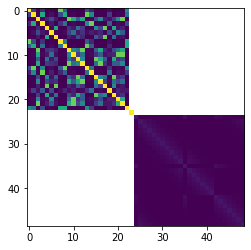

In [55]:
# build the prior; we are only doing this step to be able to look at this cool covariance matrix
# you could also record this to an external file if you really wanted to, but it is pretty huge due to the number of parameters
cov = pf.build_prior(fmt='none')

# and take a peak at a slice of the matrix
x = cov.x.copy()
x[x==0] = np.NaN
plt.imshow(x[-49:,-49:])

And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials.

In [56]:
pe = pf.draw(num_reals=100,use_specsim=True)# draw pars from the prior
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior.jcb")) #writes the paramter ensemble to binary file

# final tidy-up
pst.pestpp_options["ies_parameter_ensemble"] = "prior.jcb" #adds pest++ options to the control file
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst')) # re-writes the control file with the new pest++ options

2022-03-02 15:39:11.539094 starting: drawing realizations
2022-03-02 15:39:11.640816 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72


2022-03-02 15:39:11.800604 starting: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:11.837503 finished: SpecSim: drawing 100 realization for group npf_k_layer1_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036899
2022-03-02 15:39:11.840495 starting: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:11.877394 finished: SpecSim: drawing 100 realization for group npf_k_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036899
2022-03-02 15:39:11.879360 starting: SpecSim: drawing 100 realization for group npf_k_layer3_gr with 706 pars, (log) variance 0.05428434

2022-03-02 15:39:11.996105 finished: SpecSim: drawing 100 realization for group npf_k33_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036901
2022-03-02 15:39:11.999124 starting: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.035000 finished: SpecSim: drawing 100 realization for group npf_k33_layer3_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035876
2022-03-02 15:39:12.037993 starting: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.074893 finished: SpecSim: drawing 100 realization for group sto_ss_layer2_gr with 706 pars, (log) variance 0.

2022-03-02 15:39:12.194760 starting: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.232658 finished: SpecSim: drawing 100 realization for group rch_recharge_10_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.037898
2022-03-02 15:39:12.234653 starting: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.271569 finished: SpecSim: drawing 100 realization for group rch_recharge_11_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036916
2022-03-02 15:39:12.274546 starting: SpecSim: drawing 100 realization for group rch_recharge_12_gr with 706 pars, (log) vari

2022-03-02 15:39:12.395222 starting: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.433150 finished: SpecSim: drawing 100 realization for group rch_recharge_15_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.037928
2022-03-02 15:39:12.437139 starting: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.474010 finished: SpecSim: drawing 100 realization for group rch_recharge_16_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.036871
2022-03-02 15:39:12.477033 starting: SpecSim: drawing 100 realization for group rch_recharge_17_gr with 706 pars, (log) vari

2022-03-02 15:39:12.599695 starting: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.638580 finished: SpecSim: drawing 100 realization for group rch_recharge_2_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.038885
2022-03-02 15:39:12.641561 starting: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.677493 finished: SpecSim: drawing 100 realization for group rch_recharge_20_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035932
2022-03-02 15:39:12.680486 starting: SpecSim: drawing 100 realization for group rch_recharge_21_gr with 706 pars, (log) varian

2022-03-02 15:39:12.796168 starting: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.831074 finished: SpecSim: drawing 100 realization for group rch_recharge_24_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.034906
2022-03-02 15:39:12.834064 starting: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:12.869542 finished: SpecSim: drawing 100 realization for group rch_recharge_25_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035478
2022-03-02 15:39:12.872503 starting: SpecSim: drawing 100 realization for group rch_recharge_3_gr with 706 pars, (log) varia

2022-03-02 15:39:12.986198 starting: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:13.022114 finished: SpecSim: drawing 100 realization for group rch_recharge_6_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035916
2022-03-02 15:39:13.025093 starting: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334)
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:13.061026 finished: SpecSim: drawing 100 realization for group rch_recharge_7_gr with 706 pars, (log) variance 0.054284340773499334 (sill 0.054284340773499334) took: 0:00:00.035933
2022-03-02 15:39:13.065016 starting: SpecSim: drawing 100 realization for group rch_recharge_8_gr with 706 pars, (log) variance 

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
2022-03-02 15:39:13.334398 finished: spectral simulation for grid-scale pars took: 0:00:01.693582
2022-03-02 15:39:13.335389 starting: Drawing non-specsim pars
building diagonal cov


processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npf_k_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['npf_k33_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['npf_k33_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['sto_ss_layer2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_ss_layer3_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['sto_sy_layer1_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_1_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_10_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_11_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_12_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_13_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_14_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_15_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_16_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_17_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_18_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_19_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_2_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_20_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_21_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_22_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_23_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_24_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_25_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_3_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_4_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_5_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_6_pp']


build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_7_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['rch_recharge_8_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov


working on pargroups ['rch_recharge_9_pp']
build cov matrix
done
getting diag var cov 32
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbcond_gr']


build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcond_gr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['wel_cst']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov


working on pargroups ['sfr_gr']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov


working on pargroups ['ghbhead_gr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
adding remaining parameters to diagonal


2022-03-02 15:39:18.868452 finished: Drawing non-specsim pars took: 0:00:05.533063


2022-03-02 15:39:20.596455 finished: drawing realizations took: 0:00:09.057361


noptmax:0, npar_adj:25454, nnz_obs:920
